In [156]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt



In [157]:

tess_dict = {
    "id": "tid",
    "ra": "ra",
    "dec": "dec",
    "teff": "st_teff",
    "radius": "st_rad",
    "logg": "st_logg",
    "period": "pl_orbper",
    "transit_time_t0": "pl_tranmid",
    "planet_radius": "pl_rade",
    "duration": "pl_trandurh",
    "depth": "pl_trandep",
    "insolation": "pl_insol",
    "temperature": "pl_eqt",
    "planet_count": "pl_pnum",
    "disposition": "tfopwg_disp"
}


def standarize_dataframe(df,columns):

    df = df[columns]
    df.columns = list(tess_dict.keys())

    return  df

def scale_flux_minmax(flux_array):
    """
    Escala una serie de flujo entre 0 y 1 usando min-max scaling.
    Ignora valores np.nan en el cálculo y los conserva como np.nan.
    """
    flux_array = np.array(flux_array, dtype=np.float32)
    
    # Máscara para valores válidos
    valid_mask = ~np.isnan(flux_array)
    
    # Calcular min y max solo con valores válidos
    min_val = np.min(flux_array[valid_mask])
    max_val = np.max(flux_array[valid_mask])
    
    # Escalar
    scaled = (flux_array - min_val) / (max_val - min_val)
    
    # Conservar np.nan
    scaled[~valid_mask] = np.nan
    
    return scaled

In [158]:
tess = pd.read_csv('/kaggle/input/tess-ids/tess.csv')
tess_standarized = standarize_dataframe(tess, list(tess_dict.values()))
tess_values = tess_standarized[['id','transit_time_t0','period']].copy()

In [159]:
tess_lightcurves_non_exo = pd.read_csv('/kaggle/input/tess-series/TESS_lightcurves_non_exo.csv')
tess_lightcurves_exo = pd.read_csv('/kaggle/input/tess-series/TESS_lightcurves_exo.csv')

In [160]:
tess_lightcurves_non_exo['time'] = pd.to_datetime(tess_lightcurves_non_exo['time'], unit='s')

In [161]:
import pandas as pd
import numpy as np
from typing import Tuple

# --- Parámetros de la Transformación ---
N_BINS = 1000  # Define el número fijo de bins (columnas) para tu Autoencoder
# ----------------------------------------

def preprocess_light_curves(df_raw: pd.DataFrame, n_bins: int = N_BINS) -> pd.DataFrame:
    """
    Normaliza el flujo, aplica binning al tiempo, pivotea el DataFrame para el Autoencoder,
    e imputa NaN con 0.
    
    Args:
        df_raw: DataFrame con columnas ['id', 'time', 'flux'].
        n_bins: Número de bins fijos para la longitud de la serie de tiempo.
        
    Returns:
        DataFrame listo para el entrenamiento del Autoencoder.
    """
    # 1. Normalización del Flujo por cada ID
    
    df_normalized = df_raw.copy()
    
    # Normalización: (Flujo - Mediana) / Desviación Estándar
    df_normalized['flux_normalized'] = df_normalized.groupby('id')['flux'].transform(
        lambda x: (x - x.median()) / x.std()
    )
    
    # 🌟 TRATAMIENTO DE NAN 1: Imputar 0 después de la normalización.
    # Esto maneja los casos donde std=0 (línea plana) o datos anómalos.
    df_normalized['flux_normalized'] = df_normalized['flux_normalized'].fillna(0)
    
    # 2. Binning del Tiempo (Crear el índice de columna fija)

    def calculate_bins(series: pd.Series, max_bins: int) -> pd.Series:
        """Calcula el índice del bin [0, max_bins-1] para cada punto de tiempo."""
        time_min = series.min()
        time_max = series.max()
        time_range = time_max - time_min
        
        if time_range == 0 or pd.isna(time_range):
            return pd.Series(0, index=series.index)
        
        # Mapea el tiempo relativo [0, 1] al índice del bin [0, N_BINS-1]
        bin_index = ((series - time_min) / time_range) * (max_bins - 1)
        return np.floor(bin_index).astype(int)

    # Aplica la función de binning para obtener la columna 'bin_index'
    df_normalized['bin_index'] = df_normalized.groupby('id')['time'].transform(
        lambda x: calculate_bins(x, n_bins)
    )
    
    # 3. Agregación (Remuestreo) y Pivot
    
    # Agrupar por ID y BIN_INDEX y tomar la media del flujo normalizado
    df_binned = df_normalized.groupby(['id', 'bin_index'])['flux_normalized'].mean().reset_index()
    
    # Pivotear la tabla: 'id' como índice, 'bin_index' como columnas
    df_final = df_binned.pivot(index='id', columns='bin_index', values='flux_normalized')
    
    # 🌟 TRATAMIENTO DE NAN 2: Rellenar los NaNs restantes.
    # Estos NaNs se generan porque algunos bins no tenían ninguna observación.
    df_final = df_final.fillna(0)
    
    # Renombrar las columnas para tener nombres limpios (ej. 'flux_0', 'flux_1'...)
    df_final.columns = [f'flux_{i}' for i in range(n_bins)]
    
    # Resetear el índice si quieres 'id' como una columna normal
    df_final = df_final.reset_index()

    return df_final

In [175]:
df_ae_ready_non_exo = preprocess_light_curves(tess_lightcurves_non_exo, n_bins=1000) # Usamos 10 bins para el ejemplo

In [176]:
df_ae_ready_exo = preprocess_light_curves(tess_lightcurves_exo, n_bins=1000)

In [177]:
df_ae_ready_non_exo['disposition'] = 0

df_ae_ready_exo['disposition'] = 1 

df_ae_final = pd.concat(
    [df_ae_ready_non_exo, df_ae_ready_exo], 
    ignore_index=False
)

## Modeling

In [165]:
df_ae_final['disposition'].value_counts()

disposition
1    49
0    42
Name: count, dtype: int64

In [166]:
df_ae_final_shuffled = df_ae_final.sample(frac=1, random_state=42).reset_index(drop=True)

In [178]:
X_ae = df_ae_final_shuffled.drop(columns=['disposition','id']).values 
y_ae = df_ae_final_shuffled['disposition'].values

In [179]:
X_ae = X_ae.astype(np.float32) 

In [180]:
train_data, test_data, train_labels, test_labels = train_test_split(
    X_ae, y_ae, test_size=0.2, random_state=21
)

### Non Exo Planet

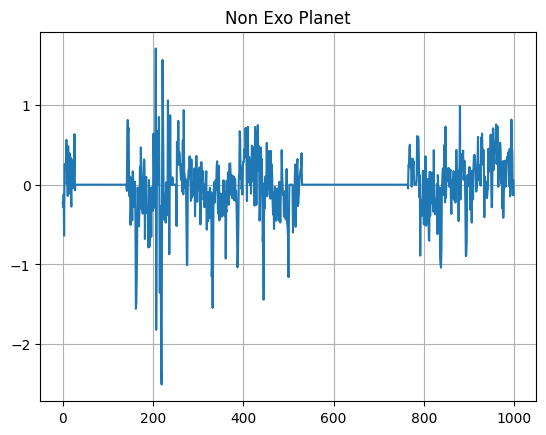

In [181]:
plt.grid()
plt.plot(np.arange(1000), train_data[0])
plt.title("Non Exo Planet")
plt.show()

## Exo PLanet

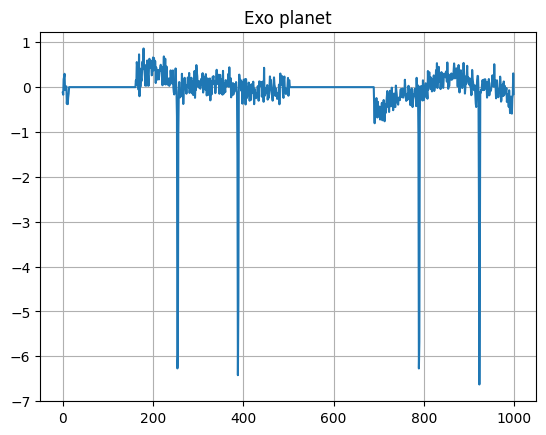

In [50]:
plt.grid()
plt.plot(np.arange(1000), train_data[1])
plt.title("Exo planet")
plt.show()

## Autoencoder

In [120]:
HE_INIT = 'he_uniform'
INPUT_DIM = 1000

class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    
    # --- ENCODER ---
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu", input_shape=(INPUT_DIM,), kernel_initializer=HE_INIT),
      layers.Dense(16, activation="relu", kernel_initializer=HE_INIT),
    ])

    # --- DECODER ---
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu", kernel_initializer=HE_INIT),
      layers.Dense(32, activation="relu", kernel_initializer=HE_INIT),
      layers.Dense(1000, activation="sigmoid") 
    ])

  def call(self, x):
    encoded = self.encoder(x)
    tf.print("Encoded shape:", tf.shape(encoded))
    decoded = self.decoder(encoded)
    return decoded

In [121]:
autoencoder.compile(optimizer='adam', loss='mae')

In [122]:
history = autoencoder.fit(train_data, train_data,
          epochs=100,
          batch_size=72, #full weights optimization
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.2403 - val_loss: 0.3156
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2440 - val_loss: 0.3165
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2428 - val_loss: 0.3176
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.2419 - val_loss: 0.3184
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2423 - val_loss: 0.3180
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2418 - val_loss: 0.3171
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2413 - val_loss: 0.3167
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2416 - val_loss: 0.3170
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2414 - val_loss: 0.3175
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2410 - val_loss: 0.3178
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.2411 - val_loss: 0.3177
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.2411 - val_loss

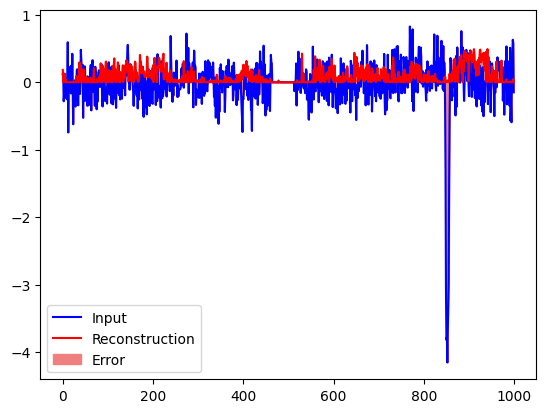

In [132]:
encoded_imgs = autoencoder.encoder(test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(test_data[1],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(1000), decoded_imgs[0], test_data[1], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

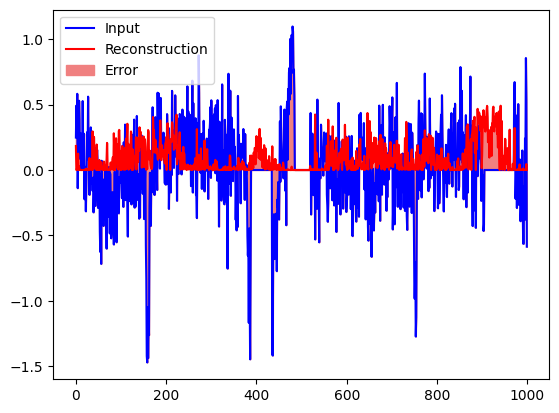

In [133]:
encoded_imgs = autoencoder.encoder(test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(test_data[3],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(1000), decoded_imgs[0], test_data[3], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [155]:
print(tf.__version__)

2.18.0


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


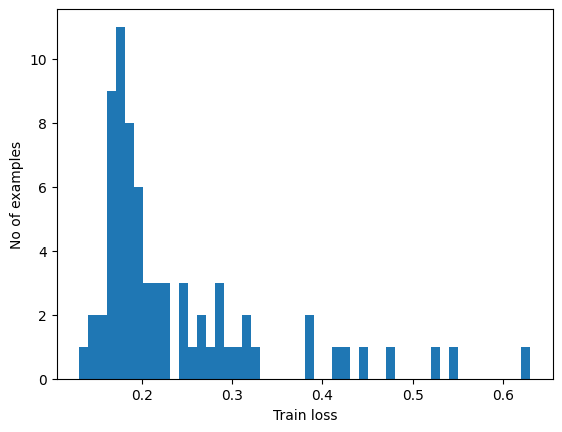

In [134]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [135]:
threshold = np.mean(train_loss) + 3*np.std(train_loss)
print(f'mean: {np.mean(train_loss)} and std  {np.std(train_loss)}')
print("Threshold: ", threshold)


mean: 0.23922747373580933 and std  0.10179061442613602
Threshold:  0.5445993170142174


In [138]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold), loss

def print_stats(predictions, labels):
  print("Recall = {}".format(recall_score(labels, predictions)))

In [139]:
preds, scores = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Recall = 0.8333333333333334


In [144]:
import joblib

In [145]:
autoencoder.save('autoencoder.h5')

In [150]:
autoencoder.save('autoencoder_exo_planet.keras')